# **Tensorflow Hub**

## **1. Tensorflow Hub 개요**

- Tensorflow Hub란?
    - 어디서나 미세 조정 및 배포 가능한 선행 학습된 모델의 포괄적인 저장소

## **2. Tensorflow Hub 사용하기**

### 2-1. TensorFlow Hub를 사용한 이미지 분류

- TensorFlow Hub의 여러 이미지 분류 모델을 시도하고 사용 사례에 가장 적합한 모델을 결정함
- TF Hub는 이미지에서 작동하는 모델에 대한 일관된 입력 규칙을 권장하기 때문에 다양한 아키텍처를 실험하여 요구 사항에 가장 적합한 아키텍처를 쉽게 찾을 수 있음

#### 2-1-1. 필요한 라이브러리 가져오기

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

#### 2-1-2. Helper functions for loading image (hidden)

- 이미지 분류 모델을 선택함
    - 일부 내부 변수가 설정되고 레이블 파일이 다운로드되어 사용할 준비가 완료됨
    - 다른 입력 크기, 모델 크기, 정확도 및 추론 시간과 같이 모델 간에는 몇 가지 기술적인 차이가 있으므로, 이 단계에서 사용 사례에 가장 적합한 모델을 찾을 때까지 사용 중인 모델을 변경할 수 있음
    - 사용자의 편의를 위해 모델의 핸들(url)이 인쇄되어 있음. 여기에서 각 모델에 대한 추가 문서를 사용할 수 있음

- 참고: 이 모든 모델은 ImageNet 데이터세트에서 훈련되었음

- 기본적인 코드 사용 템플릿

In [2]:
original_image_cache = {}

In [3]:
def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

In [4]:
def load_image_from_url(img_url):
  """Returns an image with shape [1, height, width, num_channels]."""
  user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
  response = requests.get(img_url, headers=user_agent)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

In [5]:
def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_url in original_image_cache:
    img = original_image_cache[image_url]
  elif image_url.startswith('https://'):
    img = load_image_from_url(image_url)
  else:
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
  original_image_cache[image_url] = img
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img, img_raw

In [6]:
def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

#### 2-1-3. Select an Image Classification model

- 제공되는 이미지 중 하나를 선택하거나 가지고 있는 이미지를 사용할 수 있음
- 모델의 입력 크기는 다양하며 일부 모델은 동적 입력 크기를 사용함
    - 축소되지 않은 이미지에 대한 추론 가능
    - load_image 메서드는 이미지의 크기를 예상 형식에 맞게 다시 조정함

In [7]:
image_size = 224
dynamic_size = False

model_name = "efficientnetv2-s" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/classification/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/classification/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/classification/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/classification/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/classification/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/classification/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/classification/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/classification/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/classification/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/classification/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/classification/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/classification/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/classification/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/classification/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/classification/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/classification/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/classification/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/classification/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/classification/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/classification/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/classification/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/classification/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/classification/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/classification/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/classification/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/classification/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/ilsvrc2012_classification/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/classification/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/classification/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/classification/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/classification/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/classification/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/classification/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/classification/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/classification/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300,
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "mobilenet_v2_100_224": 224,
  "mobilenet_v2_130_224": 224,
  "mobilenet_v2_140_224": 224,
  "nasnet_large": 331,
  "nasnet_mobile": 224,
  "pnasnet_large": 331,
  "resnet_v1_50": 224,
  "resnet_v1_101": 224,
  "resnet_v1_152": 224,
  "resnet_v2_50": 224,
  "resnet_v2_101": 224,
  "resnet_v2_152": 224,
  "mobilenet_v3_small_100_224": 224,
  "mobilenet_v3_small_075_224": 224,
  "mobilenet_v3_large_100_224": 224,
  "mobilenet_v3_large_075_224": 224,
}

model_handle = model_handle_map[model_name]

print(f"Selected model: {model_name} : {model_handle}")


max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []

with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels]

Selected model: efficientnetv2-s : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2
Images will be converted to 384x384
10484/10484 [==============================] - 0s 0us/step


#### 2-1-4. Select an Input Image

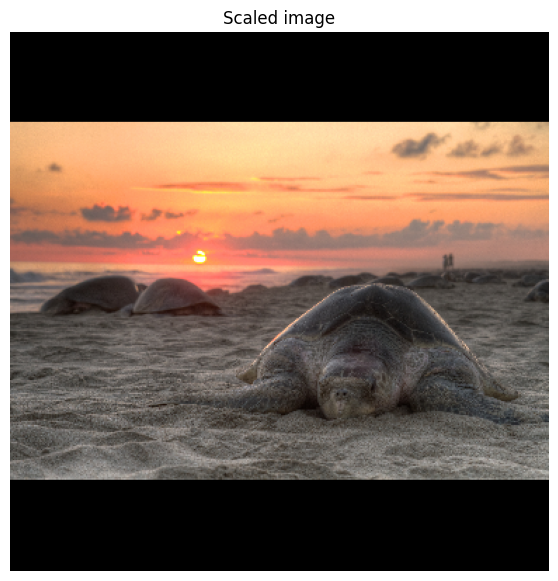

In [8]:
image_name = "turtle" # @param ['tiger', 'bus', 'car', 'cat', 'dog', 'apple', 'banana', 'turtle', 'flamingo', 'piano', 'honeycomb', 'teapot']

images_for_test_map = {
    "tiger": "https://upload.wikimedia.org/wikipedia/commons/b/b0/Bengal_tiger_%28Panthera_tigris_tigris%29_female_3_crop.jpg",
    #by Charles James Sharp, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons
    "bus": "https://upload.wikimedia.org/wikipedia/commons/6/63/LT_471_%28LTZ_1471%29_Arriva_London_New_Routemaster_%2819522859218%29.jpg",
    #by Martin49 from London, England, CC BY 2.0 <https://creativecommons.org/licenses/by/2.0>, via Wikimedia Commons
    "car": "https://upload.wikimedia.org/wikipedia/commons/4/49/2013-2016_Toyota_Corolla_%28ZRE172R%29_SX_sedan_%282018-09-17%29_01.jpg",
    #by EurovisionNim, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons
    "cat": "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg",
    #by Alvesgaspar, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "dog": "https://upload.wikimedia.org/wikipedia/commons/archive/a/a9/20090914031557%21Saluki_dog_breed.jpg",
    #by Craig Pemberton, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "apple": "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg",
    #by Abhijit Tembhekar from Mumbai, India, CC BY 2.0 <https://creativecommons.org/licenses/by/2.0>, via Wikimedia Commons
    "banana": "https://upload.wikimedia.org/wikipedia/commons/1/1c/Bananas_white_background.jpg",
    #by fir0002  flagstaffotos [at] gmail.com       Canon 20D + Tamron 28-75mm f/2.8, GFDL 1.2 <http://www.gnu.org/licenses/old-licenses/fdl-1.2.html>, via Wikimedia Commons
    "turtle": "https://upload.wikimedia.org/wikipedia/commons/8/80/Turtle_golfina_escobilla_oaxaca_mexico_claudio_giovenzana_2010.jpg",
    #by Claudio Giovenzana, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "flamingo": "https://upload.wikimedia.org/wikipedia/commons/b/b8/James_Flamingos_MC.jpg",
    #by Christian Mehlführer, User:Chmehl, CC BY 3.0 <https://creativecommons.org/licenses/by/3.0>, via Wikimedia Commons
    "piano": "https://upload.wikimedia.org/wikipedia/commons/d/da/Steinway_%26_Sons_upright_piano%2C_model_K-132%2C_manufactured_at_Steinway%27s_factory_in_Hamburg%2C_Germany.png",
    #by "Photo: © Copyright Steinway & Sons", CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "honeycomb": "https://upload.wikimedia.org/wikipedia/commons/f/f7/Honey_comb.jpg",
    #by Merdal, CC BY-SA 3.0 <http://creativecommons.org/licenses/by-sa/3.0/>, via Wikimedia Commons
    "teapot": "https://upload.wikimedia.org/wikipedia/commons/4/44/Black_tea_pot_cropped.jpg",
    #by Mendhak, CC BY-SA 2.0 <https://creativecommons.org/licenses/by-sa/2.0>, via Wikimedia Commons
}

img_url = images_for_test_map[image_name]
image, original_image = load_image(img_url, image_size, dynamic_size, max_dynamic_size)
show_image(image, 'Scaled image')

- 모델이 선택되었으면 TensorFlow Hub를 사용하여 모델을 로드함
- 기본적으로 무작위 입력이 있는 모델을 "워밍업" 실행을 통해 호출함
- 종속 호출은 종종 훨씬 더 빠르며 이를 아래의 대기 시간과 비교할 수 있음

- 참고: 동적 크기를 사용하는 모델은 각 이미지 크기에 대해 새로운 "워밍업" 실행이 필요할 수 있음

In [9]:
classifier = hub.load(model_handle)

input_shape = image.shape
warmup_input = tf.random.uniform(input_shape, 0, 1.0)
%time warmup_logits = classifier(warmup_input).numpy()

CPU times: user 2.98 s, sys: 618 ms, total: 3.6 s
Wall time: 8.8 s


- 모든 것을 추론할 준비가 되었다면 여기에서 선택한 이미지에 대한 모델의 상위 5개 결과를 볼 수 있음

CPU times: user 24.4 ms, sys: 1.19 ms, total: 25.6 ms
Wall time: 26.4 ms
(1)   35 - leatherback turtle: 0.7747844457626343
(2)   34 - loggerhead: 0.10644058883190155
(3)   37 - terrapin: 0.005874688271433115
(4)  148 - grey whale: 0.002594529651105404
(5)   36 - mud turtle: 0.002559840679168701


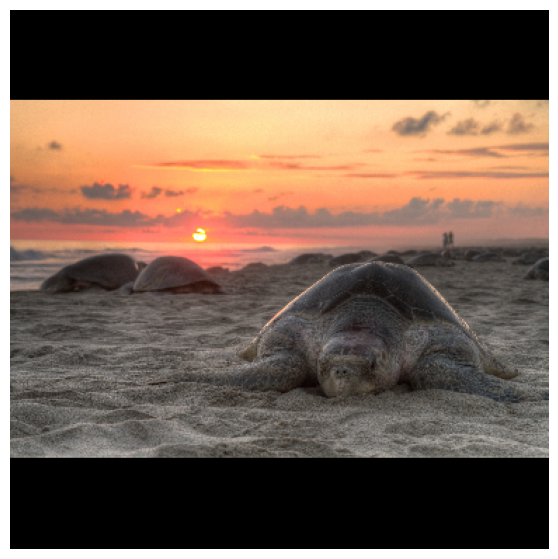

In [10]:
# Run model on image
%time probabilities = tf.nn.softmax(classifier(image)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

# Some models include an additional 'background' class in the predictions, so
# we must account for this when reading the class labels.
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(image, '')

### 2-2. 이미지 분류를 위한 전이 학습

#### 2-2-1. 전이학습 개요

- 이미지 분류 모델에는 수백만 개의 매개변수가 있으며, 처음부터 훈련하려면 레이블이 지정된 많은 훈련 데이터와 많은 컴퓨팅 성능이 필요함
- 전이 학습은 관련 작업에서 이미 훈련된 모델 조각을 가져와 새 모델에서 재사용함으로써 이러한 많은 자원 소모를 줄이는 기술임

- 이 예제에서는
    - 이미지 특성 추출을 위해 TensorFlow Hub에서 사전 훈련된 TF2 SavedModel(훨씬 크고 더 일반적인 ImageNet 데이터세트에서 훈련됨)을 사용하여
    - 5종의 꽃을 분류하기 위한 Keras 모델을 빌드하는 방법을 보여줌

#### 2-2-2. 필요한 라이브러리 가져오기

In [11]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

In [12]:
# 버전 등 환경정보 확인
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
Hub version: 0.14.0
GPU is available


#### 2-2-3. 사용할 TF2 SavedModel 모듈 선택하기

- 처음 시작하는 경우 https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4를 사용할 것
- 동일한 URL을 코드에 사용하여 SavedModel을 식별하고 브라우저에서 설명서를 표시할 수 있음
    - 참고로 TF1 Hub 형식의 모델은 여기서 작동하지 않음

- 아래의 코드에서 이미지 특성 벡터를 생성하는 더 많은 TF2 모델을 찾을 수 있음

In [13]:
model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300,
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


#### 2-2-4. Flowers 데이터세트 설정하기

- 입력은 선택한 모듈에 맞게 적절한 크기로 조정됨
- 데이터세트 확대(즉, 읽을 때마다 이미지의 임의 왜곡)를 통하여 (특히 미세 조정할 때) 훈련상황이 개선됨

In [14]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 1s 0us/step


In [15]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

In [16]:
train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [17]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False

In [18]:
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))

In [19]:
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

In [20]:
val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


#### 2-2-5. 모델 정의하기

- Hub 모듈을 사용하여 feature_extractor_layer 위에 선형 분류자를 배치하기만 하면 됨
- 속도를 높이기 위해 훈련할 수 없는 feature_extractor_layer로 시작하지만 정확성을 높이기 위해 미세 조정을 사용할 수도 있음

In [21]:
do_fine_tuning = False

In [22]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 207,622,237
Trainable params: 6,405
Non-trainable params: 207,615,832
_________________________________________________________________


#### 2-2-6. 모델 훈련하기

In [23]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [24]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5
183/183 [==============================] - 343s 2s/step - loss: 0.9777 - accuracy: 0.8965 - val_loss: 0.6137 - val_accuracy: 0.9667
Epoch 2/5
183/183 [==============================] - 327s 2s/step - loss: 0.6621 - accuracy: 0.9479 - val_loss: 0.6491 - val_accuracy: 0.9472
Epoch 3/5
183/183 [==============================] - 325s 2s/step - loss: 0.6335 - accuracy: 0.9473 - val_loss: 0.5837 - val_accuracy: 0.9694
Epoch 4/5
183/183 [==============================] - 303s 2s/step - loss: 0.5795 - accuracy: 0.9651 - val_loss: 0.5802 - val_accuracy: 0.9556
Epoch 5/5
183/183 [==============================] - 325s 2s/step - loss: 0.5340 - accuracy: 0.9808 - val_loss: 0.5364 - val_accuracy: 0.9639


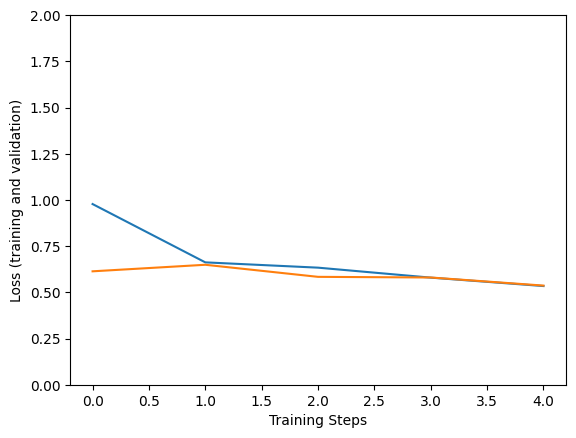

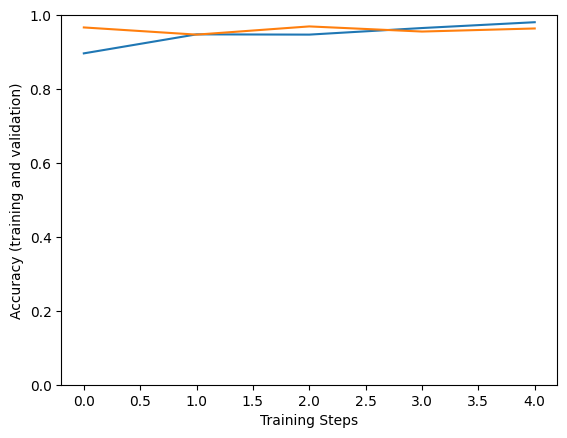

In [25]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

#### 2-2-7. 모델 검증하기

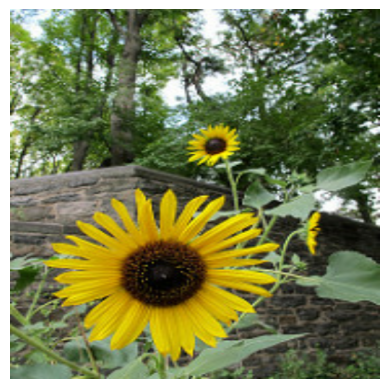

In [26]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

In [27]:
# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

1/1 [==============================] - 5s 5s/step
True label: sunflowers
Predicted label: sunflowers


#### 2-2-8. 모델 저장하기

- 훈련한 모델을 다음과 같이 TF Serving 또는 TF Lite(모바일)에 배포하기 위해 저장할 수 있음

In [28]:
saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

#### 2-2-9. 선택 사항

- TensorFlow Lite에 배포
    - TensorFlow Lite를 사용하면 TensorFlow 모델을 모바일 및 IoT 기기에 배포할 수 있음
    - 아래 코드는 훈련한 모델을 TF Lite로 변환하고 TensorFlow 모델의 최적화 도구 키트의 훈련 후 도구를 적용하는 방법을 보여줌
    - 마지막으로, TF Lite Interpreter에서 모델을 실행하여 결과 품질을 검사함
        - 최적화 없이 변환하면 이전과 동일한 결과가 제공됨(최대 반올림 오차 포함).
        - 데이터 없이 최적화를 이용해 변환하면 모델 가중치가 8bit로 양자화되지만 추론은 여전히 신경망 활성화에 부동 소수점 계산을 사용함. 그러면 모델 크기가 거의 4배 감소하고 모바일 기기의 CPU 대기 시간이 향상됨
        - 또한, 양자화 범위를 보정하기 위해 작은 참조 데이터세트가 제공되는 경우, 신경망 활성화 계산도 8bit 정수로 양자화할 수 있으며, 그 결과 모바일 기기에서 추론 속도가 빨라지고 EdgeTPU와 같은 가속기에서 실행할 수 있음

- optimization settings

In [ ]:
optimize_lite_model = False
num_calibration_examples = 60
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
num_eval_examples = 50
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))